In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [75]:
def preparar_datos_suave(df, freq='D'):
    """
    Prepara la serie temporal de ventas para ARIMA.
    - Agrupa por fecha en frecuencia diaria o mensual.
    - Interpola valores faltantes.
    """
    df = df.copy()
    df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')
    
    if freq == 'D':
        data = df.groupby('fecha')['monto_recibido'].sum()
        data = data.asfreq('D')
    elif freq == 'M':
        df['year_month'] = df['fecha'].dt.to_period('M')
        data = df.groupby('year_month')['monto_recibido'].sum()
        data = data.asfreq('M')
        data.index = data.index.to_timestamp()
    
    # Interpolación lineal y relleno de NaN
    data = data.interpolate(method='linear').fillna(0)
    data = data.reset_index()
    
    # Renombrar columna fecha si es mensual
    if freq == 'M':
        data.rename(columns={'year_month': 'fecha'}, inplace=True)
    
    return data


def dividir_series(data):
    n = len(data)
    train_size = int(n * 0.7)
    val_size = int(n * 0.15)
    train = data[:train_size]
    val = data[train_size:train_size + val_size]
    test = data[train_size + val_size:]
    trainval = pd.concat([train, val])
    return train, val, test, trainval


def prueba_adf(serie):
    resultado = adfuller(serie)
    print(f"ADF: {resultado[0]:.4f} | p-value: {resultado[1]:.4f}")
    if resultado[1] > 0.05:
        print("↳ Serie no estacionaria. Se recomienda diferenciar.\n")
    else:
        print("↳ Serie estacionaria.\n")


def seleccionar_mejor_arima(train):
    params = [(1,0,1), (2,0,2), (2,1,1), (3,0,1)]
    resultados = []
    for orden in params:
        modelo = ARIMA(train, order=orden).fit()
        resultados.append((orden, modelo.aic))
        print(f"ARIMA{orden} → AIC: {modelo.aic:.2f}")
    mejor = sorted(resultados, key=lambda x: x[1])[0]
    print(f"\n✅ Mejor modelo: ARIMA{mejor[0]} — AIC {mejor[1]:.2f}\n")
    return mejor[0]


def evaluar_modelo(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE'],
        'Valor': [mae, rmse, f"{smape:.2f}%"]
    })
    print(metricas)
    return metricas


def graficar(train, val, test, pred):
    # Asegurar que 'fecha' sea datetime
    train['fecha'] = pd.to_datetime(train['fecha'])
    val['fecha'] = pd.to_datetime(val['fecha'])
    test['fecha'] = pd.to_datetime(test['fecha'])

    # Gráfico general
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(train['fecha'], train['monto_recibido'], label='Train')
    ax.plot(val['fecha'], val['monto_recibido'], label='Validation')
    ax.plot(test['fecha'], test['monto_recibido'], label='Test')
    ax.plot(test['fecha'], pred, '--', label='Predicción ARIMA', color='black')
    ax.set_title("Predicción ARIMA")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Total Pagado")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    for pos in ['top', 'right', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Comparación real vs predicción
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(test['fecha'], test['monto_recibido'], label='Real')
    ax.plot(test['fecha'], pred, '--', label='Predicción', color='royalblue')
    ax.set_title("Real vs Predicción")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Total Pagado")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    for pos in ['top', 'right', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Distribución del error absoluto
    error = abs(test['monto_recibido'] - pred)
    plt.figure(figsize=(10, 4))
    plt.hist(error, bins=20, color='royalblue', edgecolor='black')
    plt.title("Distribución del Error Absoluto en Predicción")
    plt.xlabel("Error Absoluto")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

In [76]:
def ejecutar_arima(path, freq='D'):
    # Cargar dataset
    df = pd.read_csv(path)
    data = preparar_datos_suave(df, freq=freq)

    # Dividir series
    train, val, test, trainval = dividir_series(data)
    print(f"Train={len(train)} | Validation={len(val)} | Test={len(test)}")

    # Prueba de estacionariedad
    print("\n### Prueba ADF ###")
    prueba_adf(train['monto_recibido'])

    # Selección del mejor ARIMA
    print("\n### Selección ARIMA por AIC ###")
    mejor_order = seleccionar_mejor_arima(train['monto_recibido'])

    # Entrenar modelo final
    modelo_final = ARIMA(trainval['monto_recibido'], order=mejor_order).fit()

    # Predicción sobre test
    pred_test = modelo_final.forecast(steps=len(test))

    # Evaluación
    print("\n### Métricas ###")
    evaluar_modelo(test['monto_recibido'], pred_test)

    # Graficar resultados
    graficar(train, val, test, pred_test)

    # Exportar predicciones
    df_pred = pd.DataFrame({
        'fecha': test['fecha'].values,
        'real': test['monto_recibido'].values,
        'prediccion': pred_test
    })
    df_pred.to_csv(f"../output/prediccion_{freq}.csv", index=False)
    print(f"✅ Archivo exportado: prediccion_{freq}.csv")


Train=1773 | Validation=379 | Test=381

### Prueba ADF ###
ADF: -8.5124 | p-value: 0.0000
↳ Serie estacionaria.


### Selección ARIMA por AIC ###
ARIMA(1, 0, 1) → AIC: 29096.80
ARIMA(2, 0, 2) → AIC: 29066.44
ARIMA(2, 1, 1) → AIC: 29108.38
ARIMA(3, 0, 1) → AIC: 29058.62

✅ Mejor modelo: ARIMA(3, 0, 1) — AIC 29058.62


### Métricas ###
  Métrica       Valor
0     MAE  743.074927
1    RMSE  865.675295
2   sMAPE      34.03%


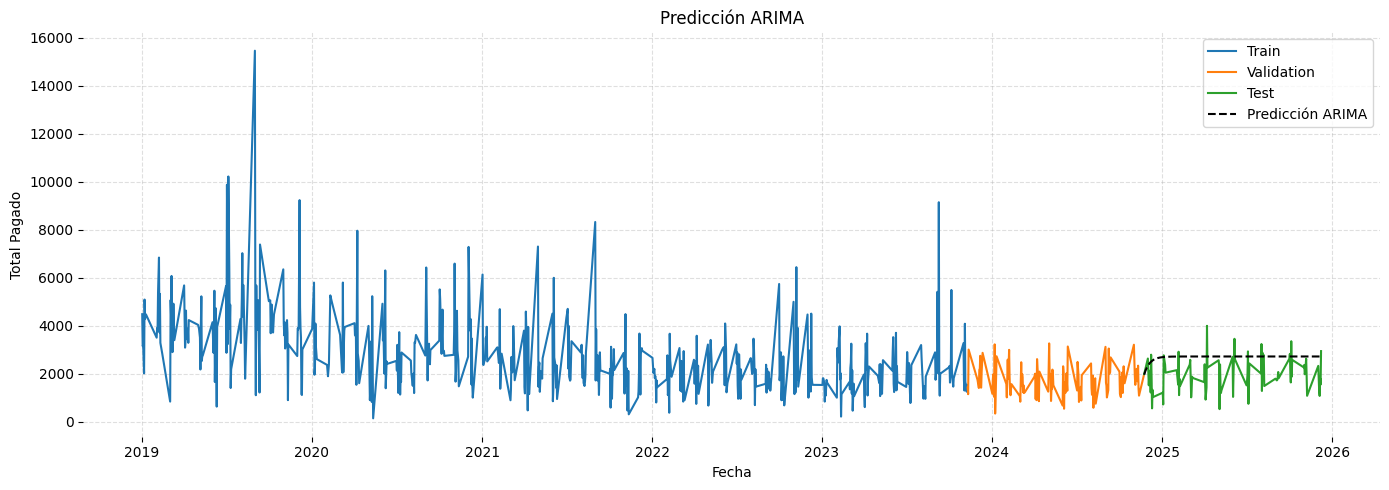

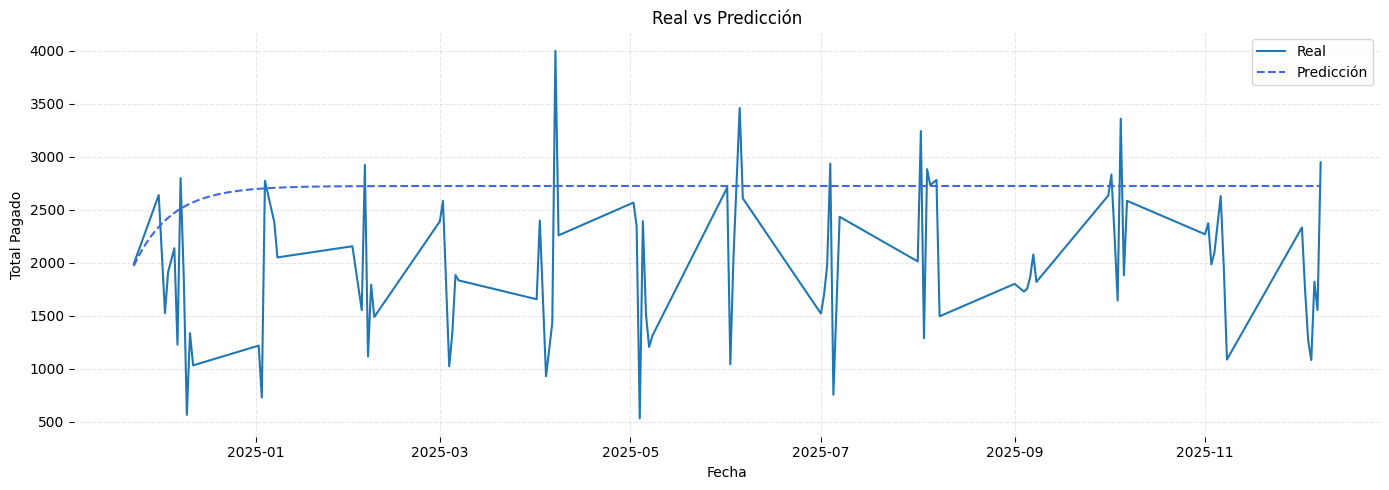

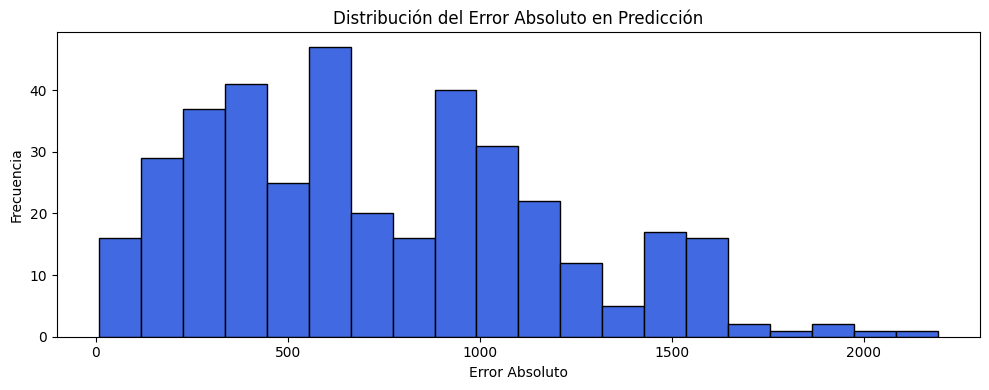

✅ Archivo exportado: prediccion_D.csv
Train=58 | Validation=12 | Test=14

### Prueba ADF ###
ADF: -3.1340 | p-value: 0.0241
↳ Serie estacionaria.


### Selección ARIMA por AIC ###
ARIMA(1, 0, 1) → AIC: 1180.80
ARIMA(2, 0, 2) → AIC: 1180.27
ARIMA(2, 1, 1) → AIC: 1170.30
ARIMA(3, 0, 1) → AIC: 1179.29

✅ Mejor modelo: ARIMA(2, 1, 1) — AIC 1170.30


### Métricas ###
  Métrica        Valor
0     MAE  6449.272449
1    RMSE  7020.121512
2   sMAPE       40.68%


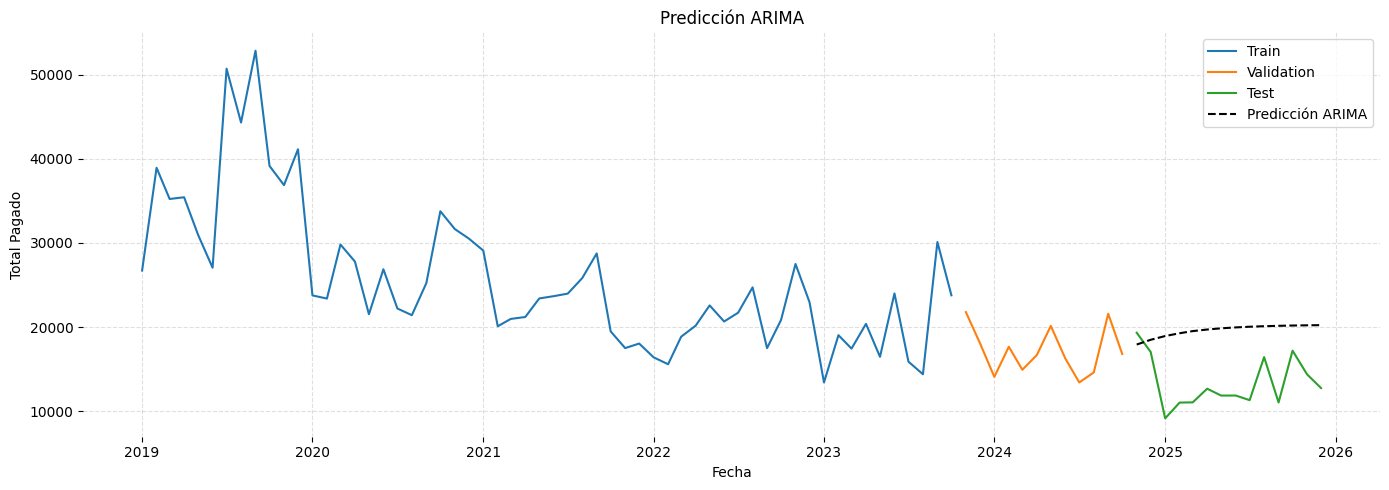

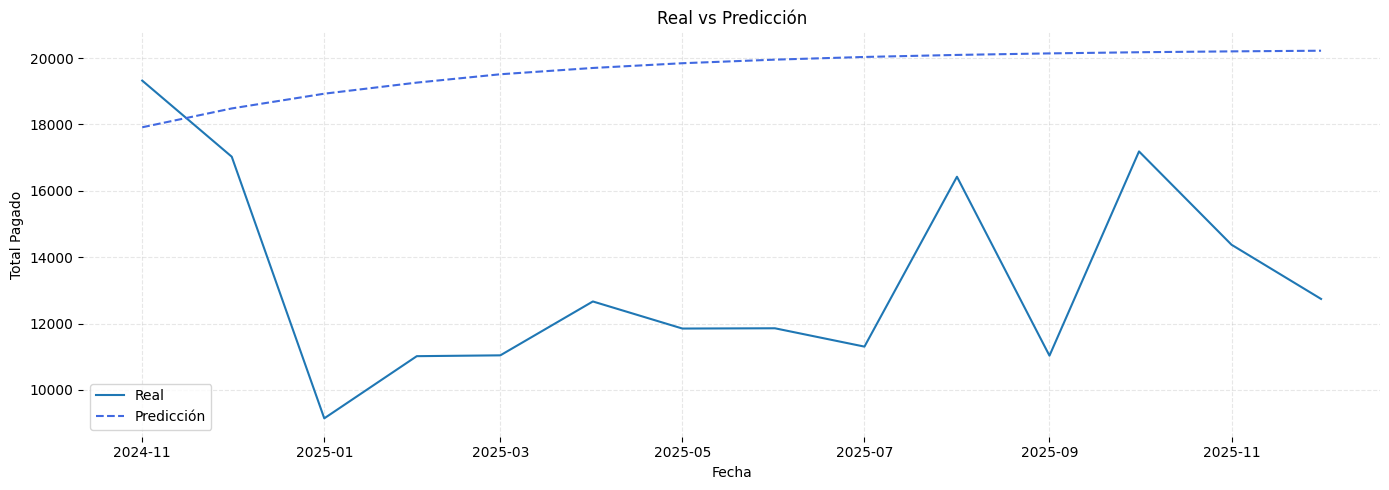

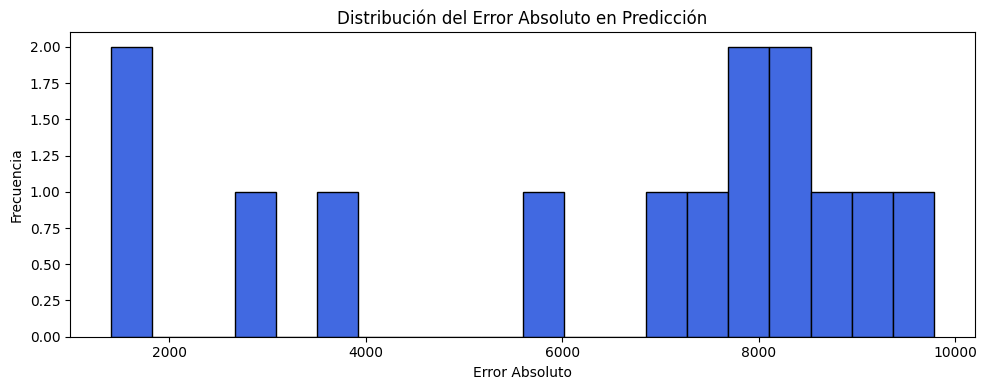

✅ Archivo exportado: prediccion_M.csv


In [77]:
ejecutar_arima("../output/dataset_venta.csv", freq='D')
ejecutar_arima("../output/dataset_venta.csv", freq='M')